#### *Set up some initial python packages for analysis*

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from IPython.display import display, Image
from sklearn import manifold
from sklearn.metrics.pairwise import pairwise_distances
from scipy import stats
import os

# Investigating the pan-genome of Nm

Thanks to the efforts of the team which made [panaroo](https://github.com/gtonkinhill/panaroo), we are now able to do pan-genome analysis on large datasets efficiently and with a manageable number of errors. This is particularly the case due to the ability to sperately compute and and then join pan-genomes of individual clusters. This has been done, and here we will do the following:

1. Look at the numbers of core/accessory in the whole collection
2. Split it up into cluster-by-cluster genes
3. Are there genes which are core in all clusters/accessory in all clusters, core in some  accesssory in some?
4. Origin of accessory genes?

In [2]:
#read in metadata
metadata = pd.read_csv("./latest_metadata_database.csv")
metadata['disease'] = metadata['disease'].replace(["Carrier"], "carrier")
relevant_clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,25,27,29,36]

/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,16,17,19,20,21,22,23,24,26,27,29,33,34,35,36,37,39,46,48,51,52,53,54,55,56,57,59,67,80,81) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
#read in the gene_presence_absence data
complete_pangenome = pd.read_csv("./panaroo_data/final_clusters/merged_pangenome/gene_presence_absence.Rtab", sep="\t")

In [6]:
complete_pangenome.columns

Index(['Gene', 'Non-unique Gene name', 'Annotation'], dtype='object')

In [55]:
#pangenome sizes
cluster_pangenome_sumaries = pd.read_csv("./panaroo_data/final_clusters/cluster_summaries.csv")

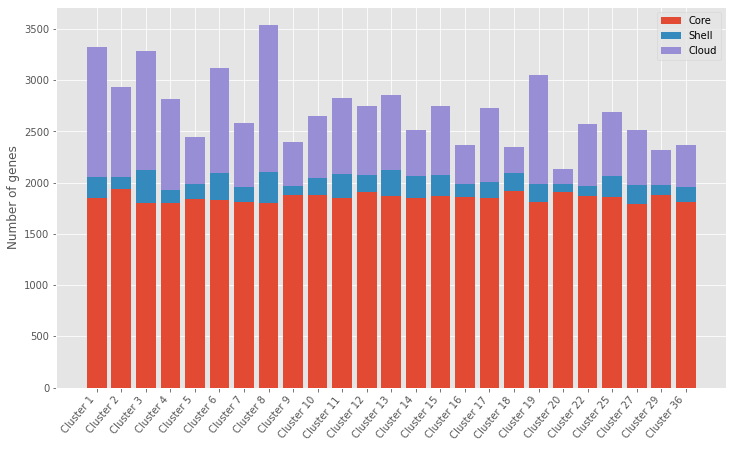

In [25]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(cluster_pangenome_sumaries["cluster"], cluster_pangenome_sumaries["core_size"], label='Core')
ax.bar(cluster_pangenome_sumaries["cluster"], cluster_pangenome_sumaries["middle_accessory_size"], bottom=cluster_pangenome_sumaries["core_size"], label='Shell')
ax.bar(cluster_pangenome_sumaries["cluster"], cluster_pangenome_sumaries["cloud_size"], bottom=(cluster_pangenome_sumaries["core_size"]+cluster_pangenome_sumaries["middle_accessory_size"]), label='Cloud')
plt.xticks(rotation=50, horizontalalignment="right")
plt.ylabel("Number of genes")
ax.legend()

In [57]:
np.sqrt(np.var(cluster_pangenome_sumaries["total_size"]))

341.2464587362043

In [22]:
#Invert the Gene-presence absence matrix to be a cluster-presence-absence matrix
#output metadata
#metadata[metadata["poppunk_cluster"].isin([str(x) for x in relevant_clusters])]
metadata[["ENA_sample_accessions", "poppunk_cluster"]].to_csv("./panaroo_data/genome_groups_file.tsv", sep='\t', header=None, index=False)

In [10]:
gene_frequences = pd.read_csv("./panaroo_data/final_clusters/cluster_presence_absence/frequencies.csv")

In [11]:
unique_genes = {}
count = 0
for gene in gene_frequences.iterrows():
#    count += 1
#    if count > 2500:
#        break
    nonzeroes = np.count_nonzero(gene[1])
    if nonzeroes == 2:
        cluster = "Cluster " + str(gene[1][gene[1] != 0].index[-1].lstrip("X"))
        unique_genes[cluster] = unique_genes.get(cluster, 0) + 1

In [12]:
unique_count_df = pd.DataFrame.from_dict(unique_genes, orient="index", columns=["Unique_genes"])

Text(0, 0.5, 'Unique Genes')

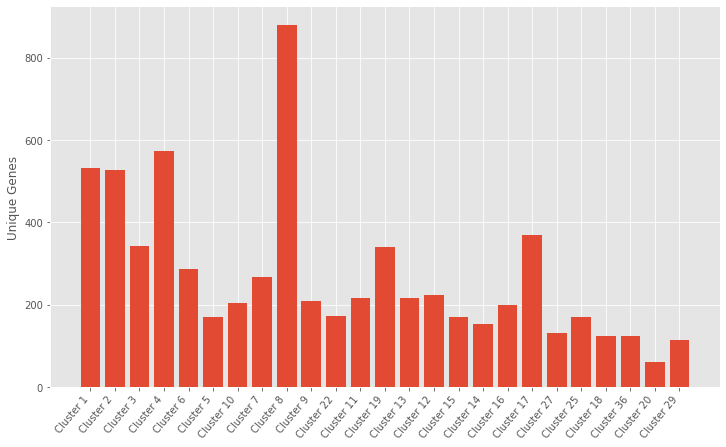

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.bar(range(len(unique_genes)), list(unique_genes.values()), align='center')
plt.xticks(range(len(unique_genes)), list(unique_genes.keys()))
plt.xticks(rotation=50, horizontalalignment="right")
plt.ylabel("Unique Genes")

In [62]:
metadata[metadata["poppunk_cluster"]=="19"]["disease"].value_counts(dropna=False)

carrier                         194
NaN                              81
invasive (unspecified/other)     25
Name: disease, dtype: int64

In [5]:
unique_gene_names = {}
count = 0
for gene in gene_frequences.iterrows():
#    count += 1
#    if count > 2500:
#        break
    nonzeroes = np.count_nonzero(gene[1])
    if nonzeroes == 2:
        cluster = "Cluster " + str(gene[1][gene[1] != 0].index[-1].lstrip("X"))
        unique_gene_names[cluster] = unique_gene_names.get(cluster, []) + [gene[1][0]]

In [46]:
for cluster in unique_gene_names.keys():
    with open("./panaroo_data/unique_gene_lists/Cluster_"+cluster.split()[1]+".txt", "w+") as outhandle:
        for gene in unique_gene_names[cluster]:
            outhandle.write(gene+'\n')

In [10]:
np.mean(cluster_pangenome_sumaries["core_size"])

1853.76

In [16]:
max(cluster_pangenome_sumaries["core_size"])

1936

In [13]:
max(cluster_pangenome_sumaries["total_size"])

3537

In [33]:
sum(list(unique_genes.values()))

6773

# Do these unique genes correlate with anything?

In [7]:
recombination_rates = pd.read_csv("./panaroo_data/average_recombination_rates.tsv", delim_whitespace=True)

In [14]:
unique_count_df["Cluster"]=unique_count_df.index
recombination_rates["Cluster"] = recombination_rates["Cluster"].str.replace("_", " ")

In [15]:
recombination_vs_unique = pd.merge(recombination_rates,unique_count_df,how="outer",on="Cluster")

In [113]:
stats.spearmanr(recombination_vs_unique["rho/theta"], recombination_vs_unique["Unique_genes"])

SpearmanrResult(correlation=-0.03616080082278686, pvalue=0.8637494785971116)

Text(0, 0.5, 'Number of Unique Genes')

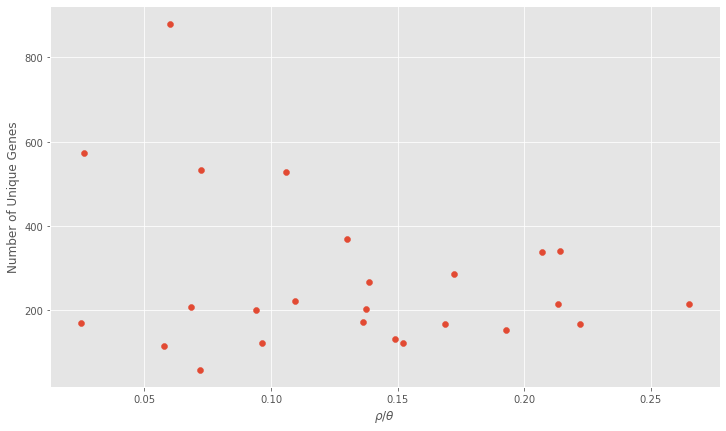

In [114]:
fig = plt.figure(figsize=(12,7))
plt.scatter( recombination_vs_unique["rho/theta"], recombination_vs_unique["Unique_genes"])
plt.xlabel(r'$\rho / \theta$')
plt.ylabel("Number of Unique Genes")

In [133]:
recombination_vs_unique.sort_values(by="rho/theta")

Cluster  rho/theta  Unique_genes
4    Cluster 5   0.024745           170
3    Cluster 4   0.026242           573
23  Cluster 29   0.057711           115
7    Cluster 8   0.059915           880
8    Cluster 9   0.068541           208
19  Cluster 20   0.071927            60
0    Cluster 1   0.072160           533
15  Cluster 16   0.093876           200
17  Cluster 18   0.096305           123
1    Cluster 2   0.105827           528
11  Cluster 12   0.109378           223
16  Cluster 17   0.129821           369
20  Cluster 22   0.136272           173
9   Cluster 10   0.137377           204
6    Cluster 7   0.138770           268
22  Cluster 27   0.149126           132
24  Cluster 36   0.152248           124
21  Cluster 25   0.168570           169
5    Cluster 6   0.172330           287
13  Cluster 14   0.192693           153
18  Cluster 19   0.207046           339
12  Cluster 13   0.213307           215
2    Cluster 3   0.214228           342
14  Cluster 15   0.222079           169
10  Cluster 11   0.265125           216

# What are these unique genes?

In [138]:
#read in ontologizer results
ontologizer_files = os.listdir("./panaroo_data/ontologizer/")
ontologizer_results = {}
for cluster in relevant_clusters:
    for file in ontologizer_files:
        if "Cluster_"+str(cluster)+"-" in file:
            ontologizer_results_file = file
    ontologizer_results["Cluster "+str(cluster)] = pd.read_csv("./panaroo_data/ontologizer/" + ontologizer_results_file, delim_whitespace=True)

In [157]:
for cluster in ontologizer_results.keys():
    print(cluster)
    print(min(ontologizer_results[cluster]["p.adjusted"]))

Cluster 1
1.0
Cluster 2
1.0
Cluster 3
1.0
Cluster 4
0.0006565132637776852
Cluster 5
1.0
Cluster 6
1.0
Cluster 7
0.7557363025312658
Cluster 8
0.0743726250481369
Cluster 9
0.17621819175518735
Cluster 10
1.0
Cluster 11
1.0
Cluster 12
1.0
Cluster 13
0.7052110764042216
Cluster 14
1.0
Cluster 15
0.16196854038669084
Cluster 16
5.276093508695584e-05
Cluster 17
0.3275302112154458
Cluster 18
0.9218025937910672
Cluster 19
0.6835560303010851
Cluster 20
0.9981378026066684
Cluster 22
0.11078285137596253
Cluster 25
0.43971099168338096
Cluster 27
0.536086735742336
Cluster 29
0.016678038375754503
Cluster 36
0.02084341385342397


In [161]:
ontologizer_results["Cluster 4"][ontologizer_results["Cluster 4"]["p.adjusted"] < 0.05]

ID  Pop.total  Pop.term  Study.total  Study.term  Pop.family  \
0  GO:0034061       8350        41          573          11         544   

   Study.family  nparents  is.trivial             p  p.adjusted         p.min  \
0            28         3       False  9.769543e-07    0.000657  1.087396e-62   

                      name  
0  DNA polymerase activity

In [162]:
ontologizer_results["Cluster 16"][ontologizer_results["Cluster 16"]["p.adjusted"] < 0.05]

ID  Pop.total  Pop.term  Study.total  Study.term  Pop.family  \
0  GO:0032196       8350       197          200          15        2331   
1  GO:0140097       8350       431          200          19        2152   

   Study.family  nparents  is.trivial             p  p.adjusted  \
0            38         1       False  1.289998e-07    0.000053   
1            37         1       False  1.804140e-05    0.007361   

           p.min                               name  
0  1.981632e-292                      transposition  
1   0.000000e+00  catalytic activity, acting on DNA

In [163]:
ontologizer_results["Cluster 29"][ontologizer_results["Cluster 29"]["p.adjusted"] < 0.05]

ID  Pop.total  Pop.term  Study.total  Study.term  Pop.family  \
0  GO:0032196       8350       197          115           6        2331   

   Study.family  nparents  is.trivial         p  p.adjusted          p.min  \
0            11         1       False  0.000109    0.016678  1.981632e-292   

            name  
0  transposition

In [164]:
ontologizer_results["Cluster 29"][ontologizer_results["Cluster 36"]["p.adjusted"] < 0.05]

/Users/nm12/anaconda/envs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


ID  Pop.total  Pop.term  Study.total  Study.term  Pop.family  \
0  GO:0032196       8350       197          115           6        2331   

   Study.family  nparents  is.trivial         p  p.adjusted          p.min  \
0            11         1       False  0.000109    0.016678  1.981632e-292   

            name  
0  transposition

In [166]:
ontologizer_results["Cluster 8"][ontologizer_results["Cluster 8"]["p.adjusted"] < 0.1]

ID  Pop.total  Pop.term  Study.total  Study.term  Pop.family  \
0  GO:0003723       8350       179          880          31         959   

   Study.family  nparents  is.trivial         p  p.adjusted          p.min  \
0            87         1       False  0.000062    0.074373  1.026369e-199   

          name  
0  RNA binding

# What about genes which are neither core nor unique?

In [51]:
gene_distribution_hist = [0]*25
for gene in gene_frequences.iterrows():
    nonzeroes = np.count_nonzero(gene[1])
    if nonzeroes == 2:
        continue
    else:
        gene_distribution_hist[nonzeroes-2] += 1

Text(0.5, 0, 'Number of Clusters')

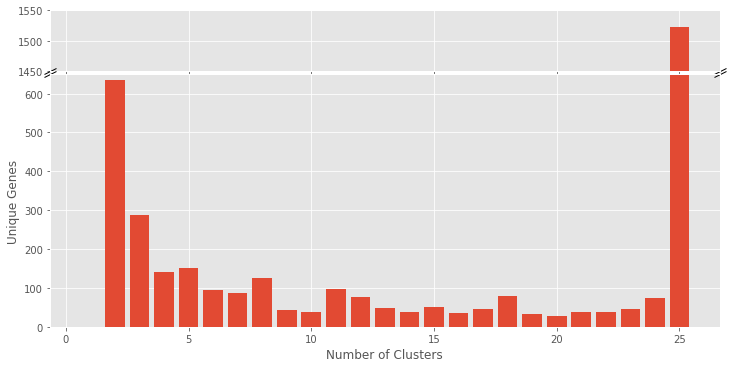

In [130]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_gridspec(6, 1)
ax1 = fig.add_subplot(ax[0, 0])
ax2 = fig.add_subplot(ax[1:5, 0])

ax1.bar(np.arange(len(gene_distribution_hist))+1, gene_distribution_hist, align='center')
ax2.bar(np.arange(len(gene_distribution_hist))+1, gene_distribution_hist, align='center')
fig.subplots_adjust(hspace=0.05) 
ax1.set_ylim(1450, 1550)  # outliers only
ax2.set_ylim(0, 650)  # most of the data

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


plt.ylabel("Unique Genes", loc="center")
plt.xlabel("Number of Clusters")

In [71]:
np.arange(len(gene_distribution_hist))+1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

In [28]:
#can we tsne the thing?

def pw_sim(input_file):
        
    # Load Data
    # specifies data types for import; first column string (gene names), all others bool for similarity calc
    
    col_names = pd.read_csv(input_file, nrows=0, sep = '\t').columns
    types_dict = {'Gene': str}
    types_dict.update({col: bool for col in col_names if col not in types_dict})
    
    data = pd.read_csv(input_file, sep = '\t', dtype=types_dict)
    
    # For Isolate-Isolate Comparison
    print("\n-----------------------------------------------\n")
    print("Calculating pairwise distance between isolates...\n")

    isols = data.iloc[:,1:]
    isols_trans = isols.transpose()
    isols_jac_sim = pd.DataFrame((1 - pairwise_distances(isols_trans.to_numpy(), metric = "jaccard", n_jobs = 1)), index=isols.columns, columns=isols.columns)


    print(" - Isolate pairwise distance calculated\n")

    return isols_jac_sim


def generate_tsne(seqLabels, accMat, perplexity, verbosity = 0):
    """Generate t-SNE projection using accessory distances
    Writes a plot of t-SNE clustering of accessory distances (.dot)
    Args:
        seqLabels (list)
            Processed names of sequences being analysed.
        accMat (numpy.array)
            n x n array of accessory distances for n samples.
        perplexity (int)
            Perplexity parameter passed to t-SNE
        overwrite (bool)
            Overwrite existing output if present
            (default = False)
        verbosity (int)
            Verbosity of t-SNE process (0-3)
            (default = 0)
    """
    # generate accessory genome distance representation
    tsne_filename = "./panaroo_data/grapple/jacard_tsne_distances.dot"

    print("Running t-SNE\n")
    accArray_embedded = manifold.TSNE(n_components=2, perplexity=perplexity, verbose=verbosity).fit_transform(np.array(accMat))

    return accArray_embedded
    # print dot file
    #with open(tsne_filename, 'w') as nFile:
    #    nFile.write("graph G { ")
    #    for s, seqLabel in enumerate(seqLabels):
    #        nFile.write('"' + seqLabel + '"' +
    #                    '[x='+str(5*float(accArray_embedded[s][0]))+',y='+str(5*float(accArray_embedded[s][1]))+']; ')
    #    nFile.write("}\n")

In [23]:
pangenome_jacard_distances = pw_sim("./panaroo_data/final_clusters/cluster_36/gene_presence_absence.Rtab")


-----------------------------------------------

Calculating pairwise distance between isolates...

 - Isolate pairwise distance calculated



In [29]:
tsne = generate_tsne(pangenome_jacard_distances.index, np.array(pangenome_jacard_distances), 30)

Running t-SNE



In [33]:
len(tsne)

112

# Let's finally take a look at rates!

In [3]:
#read in the rate results
panaroo_fmg_results = pd.read_csv("./panaroo_data/panaroo_fmg/fmg_results_summary.csv")

In [4]:
panaroo_fmg_results

Cluster         a   a_lower   a_upper         v   v_lower   v_upper  \
0         1  0.009807  0.008520  0.011238  0.003568  0.002938  0.004240   
1         2  0.019454  0.015962  0.022346  0.001430  0.001166  0.001737   
2         3  0.001022  0.000927  0.001125  0.000359  0.000328  0.000399   
3         4  0.002593  0.002333  0.002889  0.000608  0.000540  0.000703   
4         5  0.007328  0.005868  0.008870  0.000679  0.000555  0.000782   
5         6  0.000876  0.000779  0.001007  0.000276  0.000239  0.000316   
6         7  0.002330  0.002027  0.002691  0.000308  0.000272  0.000357   
7         8  0.005141  0.004659  0.005553  0.002465  0.002208  0.002693   
8         9  0.005122  0.004074  0.006183  0.000451  0.000376  0.000547   
9        10  0.003280  0.002837  0.003805  0.000566  0.000493  0.000642   
10       11  0.001357  0.001184  0.001545  0.000215  0.000185  0.000239   
11       12  0.004547  0.003958  0.005372  0.000696  0.000613  0.000783   
12       13  0.001027  0.000890  0.001240  0.000192  0.000165  0.000209   
13       14  0.003239  0.002808  0.003734  0.000399  0.000354  0.000454   
14       15  0.000940  0.000813  0.001088  0.000184  0.000161  0.000209   
15       16  0.004225  0.003675  0.004970  0.000500  0.000419  0.000578   
16       17  0.000871  0.000768  0.000971  0.000194  0.000173  0.000215   
17       18  0.002250  0.001856  0.002714  0.000129  0.000111  0.000146   
18       19  0.001097  0.001006  0.001220  0.000230  0.000198  0.000270   
19       20  0.006943  0.005456  0.008816  0.000229  0.000188  0.000273   
20       22  0.001035  0.000846  0.001224  0.000152  0.000123  0.000171   
21       25  0.001051  0.000928  0.001179  0.000201  0.000177  0.000222   
22       27  0.001317  0.001111  0.001461  0.000177  0.000156  0.000200   
23       29  0.000626  0.000531  0.000755  0.000081  0.000071  0.000091   
24       36  0.001013  0.000889  0.001149  0.000128  0.000116  0.000145   

              G      G_lower      G_upper            M      M_lower  \
0   1964.390255  1918.731515  2005.644770  2679.145214  2580.428768   
1   1992.170609  1965.416111  2027.535986  2138.645229  2108.966896   
2   2002.162132  1962.819926  2059.282937  2706.481477  2657.350518   
3   1880.380661  1831.036016  1925.426867  2321.054893  2254.648845   
4   1933.279001  1901.927937  1966.460059  2112.478371  2081.788773   
5   2010.375887  1958.402553  2061.995745  2643.949928  2560.084416   
6   1901.836268  1865.217121  1943.537588  2153.268412  2115.953120   
7   1996.401709  1953.510310  2053.612019  2953.730545  2879.252159   
8   1936.729167  1906.991725  1964.877199  2107.295427  2082.784807   
9   1982.424710  1949.910328  2016.010232  2324.475942  2289.090685   
10  1994.979228  1955.883012  2025.533234  2311.706546  2261.655908   
11  2031.783394  1994.910650  2063.487094  2342.909959  2303.946188   
12  2043.027211  2012.051190  2079.524490  2423.965800  2384.358681   
13  1979.782805  1948.490611  2014.391855  2223.711229  2193.910989   
14  2006.907895  1979.091667  2044.374890  2399.271307  2370.175567   
15  1943.892157  1914.826593  1977.462377  2173.922376  2133.057465   
16  1944.356021  1913.267016  1984.675131  2377.348110  2343.817098   
17  2028.780488  2002.660163  2048.374797  2145.048202  2122.064422   
18  1943.043478  1901.382441  1987.349080  2351.062531  2275.123110   
19  1961.581818  1946.868182  1976.937727  2026.364644  2014.050537   
20  1935.024570  1896.699017  1973.190663  2219.074177  2173.322207   
21  1994.040000  1962.088800  2027.888400  2374.406407  2336.130858   
22  1919.743056  1884.466493  1946.331076  2178.381835  2149.475329   
23  1947.224299  1923.550701  1973.462383  2198.053372  2182.245232   
24  1911.535714  1880.525446  1936.966071  2153.492732  2125.154941   

        M_upper  
0   2762.309651  
1   2185.174411  
2   2789.000793  
3   2394.051913  
4   2139.739073  
5   2709.185844  
6   2201.438522  
7   3049.553133  
8   2138.846050  
9   2356.189315  
10  2339

No handles with labels found to put in legend.


Text(0, 0.5, 'Gene loss rate, $v$, Gene gain rate, $a$')

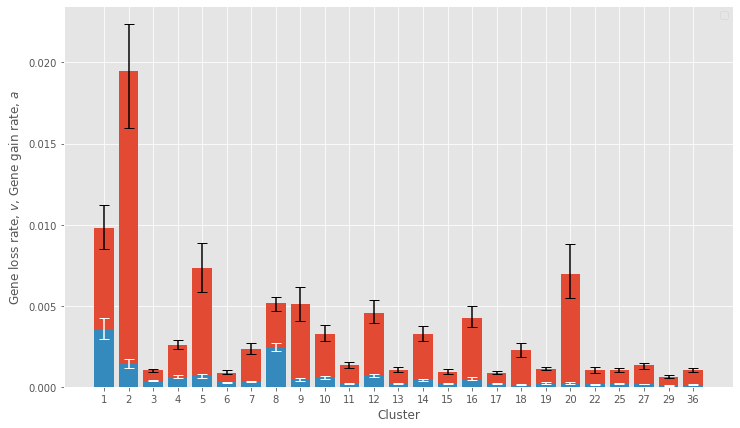

In [245]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(panaroo_fmg_results["Cluster"].astype(str), panaroo_fmg_results["a"])
ax.errorbar(panaroo_fmg_results["Cluster"].astype(str), panaroo_fmg_results["a"], fmt="none", color="black", capsize =5, yerr=((panaroo_fmg_results["a"]-panaroo_fmg_results["a_lower"]), (panaroo_fmg_results["a_upper"]-panaroo_fmg_results["a"])))
ax.bar(panaroo_fmg_results["Cluster"].astype(str), panaroo_fmg_results["v"])
ax.errorbar(panaroo_fmg_results["Cluster"].astype(str), panaroo_fmg_results["v"], fmt="none", color="white", capsize =5, yerr=((panaroo_fmg_results["v"]-panaroo_fmg_results["v_lower"]), (panaroo_fmg_results["v_upper"]-panaroo_fmg_results["v"])))
ax.legend()
plt.xlabel(r'Cluster')
plt.ylabel("Gene loss rate, $v$, Gene gain rate, $a$")

In [5]:
a_uncertainty_up_pc = (panaroo_fmg_results["a_upper"]-panaroo_fmg_results["a"])/panaroo_fmg_results["a"]
a_uncertainty_down_pc = (panaroo_fmg_results["a"]-panaroo_fmg_results["a_lower"])/panaroo_fmg_results["a"]
v_uncertainty_up_pc = (panaroo_fmg_results["v_upper"]-panaroo_fmg_results["v"])/panaroo_fmg_results["v"]
v_uncertainty_down_pc = (panaroo_fmg_results["v"]-panaroo_fmg_results["v_lower"])/panaroo_fmg_results["v"]

a_over_v = panaroo_fmg_results["a"]/panaroo_fmg_results["v"]

av_up = (a_uncertainty_up_pc+v_uncertainty_up_pc) * a_over_v
av_down = (a_uncertainty_down_pc + v_uncertainty_down_pc) * a_over_v

Text(0, 0.5, 'Relative gene gain rate, $\\frac{a}{v}$')

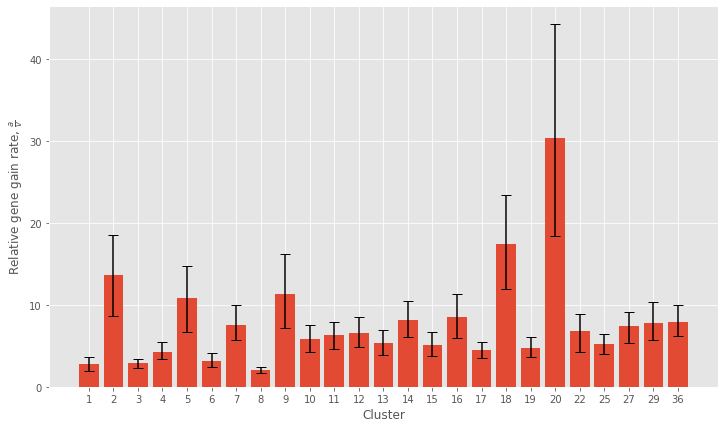

In [248]:
fig = plt.figure(figsize=(12,7))
plt.bar(panaroo_fmg_results["Cluster"].astype(str), (panaroo_fmg_results["a"]/panaroo_fmg_results["v"]))
plt.errorbar(panaroo_fmg_results["Cluster"].astype(str), a_over_v, fmt="none", color="black", capsize =5, yerr=(av_down,av_up))
plt.xlabel(r'Cluster')
plt.ylabel(r"Relative gene gain rate, $\frac{a}{v}$")

In [251]:
np.mean(net_gain_rates)

7.848779473194178

In [6]:
net_gain_rates = (panaroo_fmg_results["a"]/panaroo_fmg_results["v"])

In [16]:
recombination_vs_unique["a/v"] = net_gain_rates

In [49]:
recombination_vs_unique.sort_values(by="a/v")

Cluster  rho/theta  Unique_genes        a/v
7    Cluster 8   0.059915           880   2.085388
0    Cluster 1   0.072160           533   2.748341
2    Cluster 3   0.214228           342   2.842692
5    Cluster 6   0.172330           287   3.173077
3    Cluster 4   0.026242           573   4.267053
16  Cluster 17   0.129821           369   4.490509
18  Cluster 19   0.207046           339   4.762144
14  Cluster 15   0.222079           169   5.114933
21  Cluster 25   0.168570           169   5.242412
12  Cluster 13   0.213307           215   5.363149
9   Cluster 10   0.137377           204   5.795695
10  Cluster 11   0.265125           216   6.298713
11  Cluster 12   0.109378           223   6.530412
20  Cluster 22   0.136272           173   6.812279
22  Cluster 27   0.149126           132   7.422478
6    Cluster 7   0.138770           268   7.564020
23  Cluster 29   0.057711           115   7.766563
24  Cluster 36   0.152248           124   7.900285
13  Cluster 14   0.192693           153   8.116253
15  Cluster 16   0.093876           200   8.450600
4    Cluster 5   0.024745           170  10.788431
8    Cluster 9   0.068541           208  11.354707
1    Cluster 2   0.105827           528  13.600792
17  Cluster 18   0.096305           123  17.449262
19  Cluster 20   0.071927            60  30.279300

In [ ]:
recombination_vs_unique.sort_values(by="a/v")

In [204]:
stats.spearmanr(recombination_vs_unique["a/v"], recombination_vs_unique["Unique_genes"])

SpearmanrResult(correlation=-0.6543566191442601, pvalue=0.0003873795810120486)

In [207]:
stats.spearmanr(recombination_vs_unique["a/v"], recombination_vs_unique["rho/theta"])

SpearmanrResult(correlation=-0.2892307692307692, pvalue=0.16082608766934542)

Text(0, 0.5, 'Number of Unique Genes')

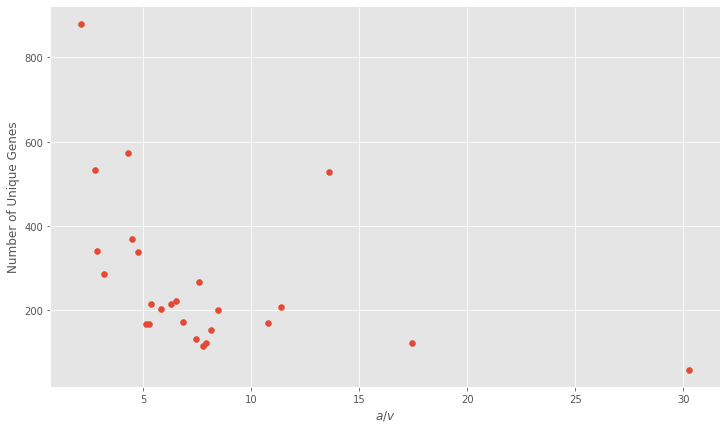

In [210]:
fig = plt.figure(figsize=(12,7))
plt.scatter( recombination_vs_unique["a/v"], recombination_vs_unique["Unique_genes"])
plt.xlabel(r'$a/v$')
plt.ylabel("Number of Unique Genes")

Text(0, 0.5, '$a/v$')

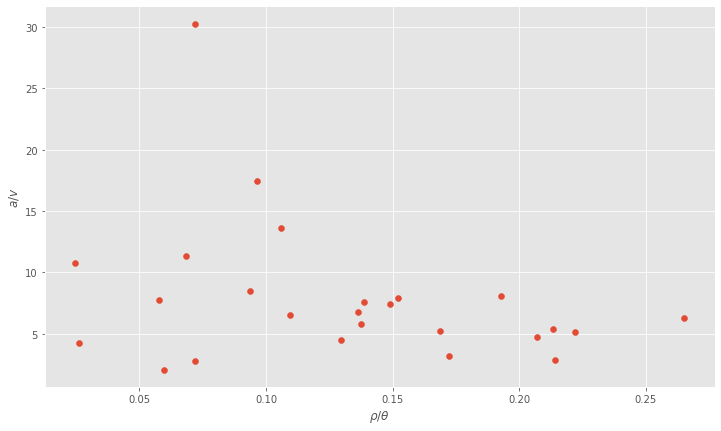

In [211]:
fig = plt.figure(figsize=(12,7))
plt.scatter( recombination_vs_unique["rho/theta"], recombination_vs_unique["a/v"])
plt.xlabel(r'$\rho / \theta$')
plt.ylabel(r'$a/v$')

In [40]:
disease_percentages = []
for cluster in relevant_clusters:
    clusterdf = metadata[metadata["poppunk_cluster"] == str(cluster)]
    total = sum(clusterdf["disease"].value_counts())
    try:
        carrier = clusterdf["disease"].value_counts()["carrier"]
        pc_carrier = float(carrier)/float(total)
    except:
        pc_carrier = 0
    pc_disease = 1 - pc_carrier
    disease_percentages.append(pc_disease)

In [253]:
disease_percentages

[0.4634920634920635,
 0.01465457083042565,
 0.9605911330049262,
 0.001280409731113985,
 0.11525974025974028,
 0.8869969040247678,
 0.9069767441860466,
 0.5629820051413882,
 0.07194244604316546,
 0.9408945686900958,
 0.9936102236421726,
 0.9962264150943396,
 0.8820960698689957,
 1,
 1,
 0.016483516483516536,
 0.04761904761904767,
 0.8947368421052632,
 0.11415525114155256,
 0.8484848484848485,
 0.011235955056179803,
 0.37037037037037035,
 0.23636363636363633,
 0.040000000000000036,
 0.07766990291262132]

Text(0, 0.5, '% disease')

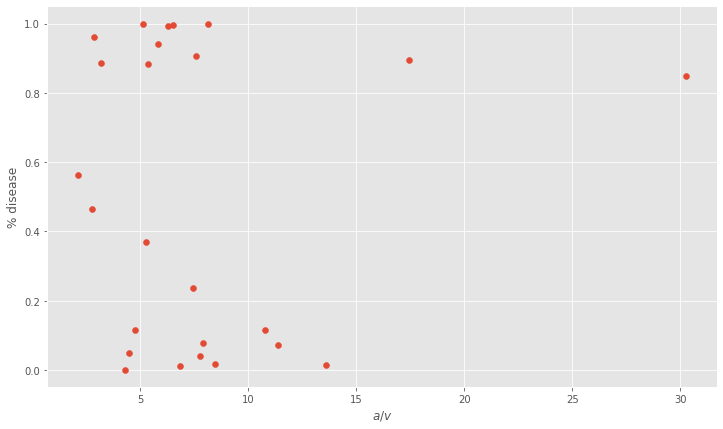

In [254]:
fig = plt.figure(figsize=(12,7))
plt.scatter( recombination_vs_unique["a/v"], disease_percentages)
plt.xlabel(r'$a/v$')
plt.ylabel(r'% disease')

In [255]:
stats.spearmanr(recombination_vs_unique["a/v"], disease_percentages)

SpearmanrResult(correlation=-0.14733602888433367, pvalue=0.4821709785595557)

# What about size?

Text(0, 0.5, 'Inferred pangenome size, $M$')

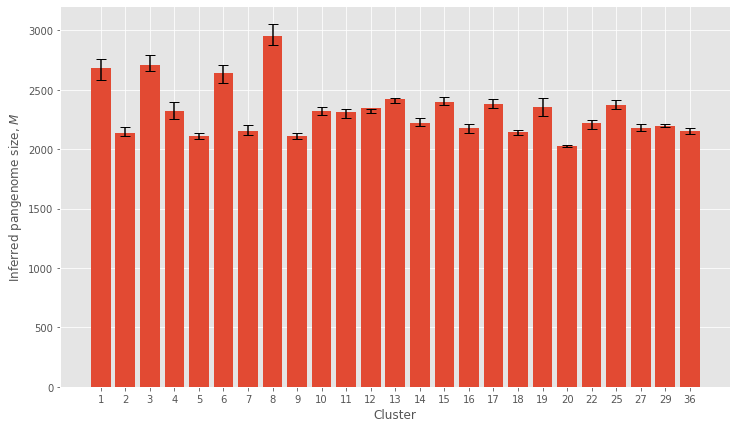

In [43]:
fig = plt.figure(figsize=(12,7))
plt.bar(panaroo_fmg_results["Cluster"].astype(str), panaroo_fmg_results["M"])
plt.errorbar(panaroo_fmg_results["Cluster"].astype(str), panaroo_fmg_results["M"], fmt="none", color="black", capsize =5, yerr=((panaroo_fmg_results["M"]-panaroo_fmg_results["M_lower"]),(panaroo_fmg_results["M_upper"]-panaroo_fmg_results["M"])))
plt.xlabel(r'Cluster')
plt.ylabel(r"Inferred pangenome size, $M$")

In [54]:
np.sqrt(np.var(panaroo_fmg_results["M"]))

217.16775119894223

Text(0, 0.5, 'Inferred pangenome size, $M$')

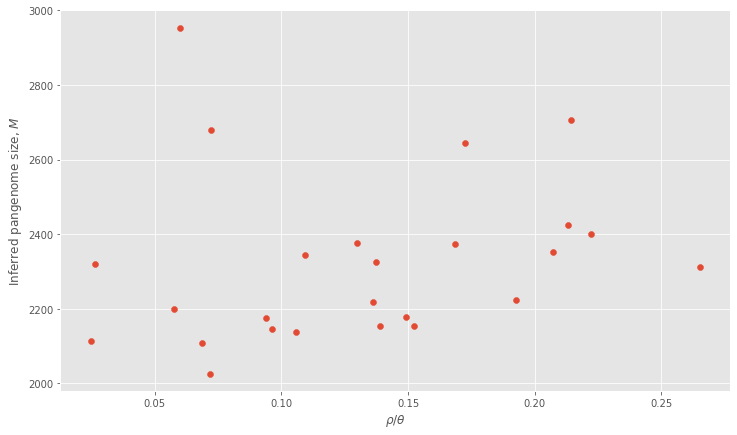

In [46]:
fig = plt.figure(figsize=(12,7))
plt.scatter(recombination_vs_unique["rho/theta"], panaroo_fmg_results["M"])
plt.xlabel(r'$\rho / \theta$')
plt.ylabel(r"Inferred pangenome size, $M$")

In [47]:
stats.spearmanr(recombination_vs_unique["rho/theta"], panaroo_fmg_results["M"])

SpearmanrResult(correlation=0.4076923076923077, pvalue=0.043077118260726716)

Text(0.5, 0, 'Inferred pangenome size, $M$')

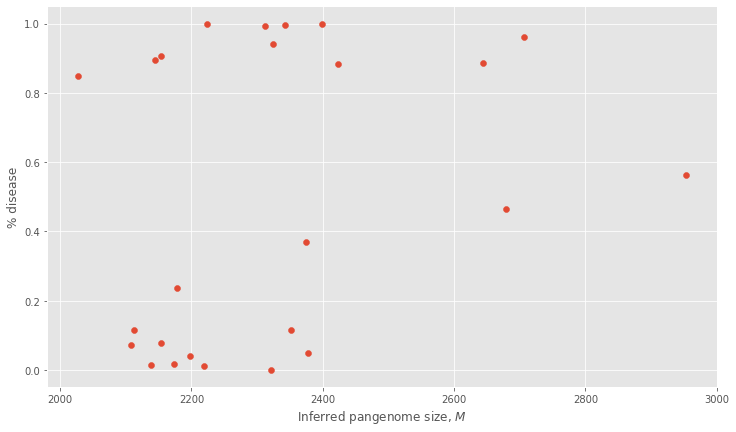

In [48]:
fig = plt.figure(figsize=(12,7))
plt.scatter(panaroo_fmg_results["M"], disease_percentages)
plt.ylabel(r'% disease')
plt.xlabel(r"Inferred pangenome size, $M$")

In [41]:
stats.spearmanr(panaroo_fmg_results["M"], disease_percentages)

SpearmanrResult(correlation=0.31313714755051597, pvalue=0.12746971896129494)

Text(0.5, 0, 'Inferred pangenome size, $M$')

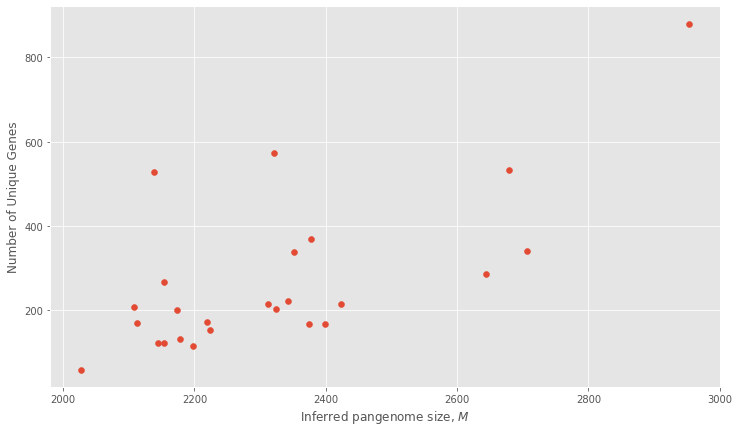

In [50]:
fig = plt.figure(figsize=(12,7))
plt.scatter(panaroo_fmg_results["M"], recombination_vs_unique["Unique_genes"])
plt.ylabel(r'Number of Unique Genes')
plt.xlabel(r"Inferred pangenome size, $M$")

In [42]:
stats.spearmanr(panaroo_fmg_results["M"], recombination_vs_unique["Unique_genes"])

SpearmanrResult(correlation=0.5347182249326993, pvalue=0.005889513088937124)

Text(0.5, 0, 'Inferred pangenome size, $M$')

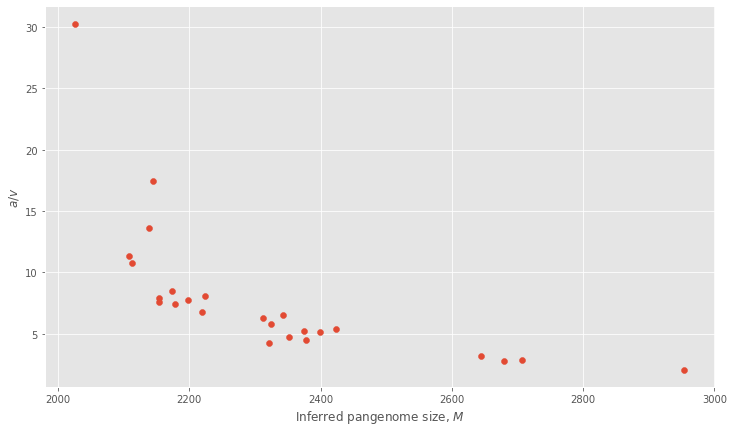

In [59]:
fig = plt.figure(figsize=(12,7))
plt.scatter(panaroo_fmg_results["M"], recombination_vs_unique["a/v"])
plt.ylabel(r'$a/v$')
plt.xlabel(r"Inferred pangenome size, $M$")

In [58]:
stats.spearmanr(panaroo_fmg_results["M"], recombination_vs_unique["a/v"])

SpearmanrResult(correlation=-0.9361538461538461, pvalue=6.3306483162071954e-12)

# Lets look up some more information about the GWAS hits

In [64]:
gene_frequences[gene_frequences["Gene"] == "mafB17"]

Gene   X1  X10  X11  X12  X13  X14  X15  X16  X17  ...  X27  X29   X3  \
2283  mafB17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

      X36   X4   X5   X6   X7   X8   X9  
2283  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 26 columns]

In [66]:
gene_frequences.loc[2283]

Gene      mafB17
X1             0
X10            0
X11            0
X12            0
X13            0
X14            0
X15            0
X16            0
X17            0
X18            0
X19            0
X2      0.996518
X20            0
X22            0
X25            0
X27            0
X29            0
X3             0
X36            0
X4             0
X5             0
X6             0
X7             0
X8             0
X9             0
Name: 2283, dtype: object

In [75]:
complete_pangenome[complete_pangenome["Gene"] =="mafB17"]

Gene  ERS006904  ERS006914  ERS006964  ERS006965  ERS006968  \
2283  mafB17          0          0          0          0          0   

      ERS006971  ERS006972  ERS006989  ERS007010  ...  ERS4396863  ERS4396864  \
2283          0          0          0          0  ...           0           0   

      ERS4396865  ERS4396872  ERS4396873  ERS4396874  ERS4396875  ERS4396876  \
2283           0           0           0           0           0           0   

      ERS4396877  ERS4396888  
2283           0           0  

[1 rows x 12121 columns]

In [85]:
cluster_2 = list(metadata[metadata["poppunk_cluster"]=="2"]["ENA_sample_accessions"])

In [86]:
for column in complete_pangenome.columns:
    if column in cluster_2:
        if complete_pangenome.at[2283, column] == 0:
            print(column)

ERS1067644
ERS1113031
ERS1113127
ERS1984208
ERS1984412


In [87]:
complete_pangenome.at[2283, "ERS3551788"]

1

In [89]:
#Result 2, pilX
gene_frequences[gene_frequences["Gene"] == "pilX~~~fimA~~~fimA_2"]

Gene   X1  X10  X11  X12  X13  X14  X15  X16  X17  ...  \
2552  pilX~~~fimA~~~fimA_2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

      X27  X29   X3  X36   X4   X5        X6   X7   X8       X9  
2552  0.0  0.0  0.0  0.0  0.0  0.0  0.984973  0.0  0.0  0.00463  

[1 rows x 26 columns]

In [91]:
gene_frequences.loc[2552]

Gene    pilX~~~fimA~~~fimA_2
X1                         0
X10                        0
X11                        0
X12                        0
X13                        0
X14                        0
X15                        0
X16                        0
X17                        0
X18                        0
X19                        0
X2                         0
X20                        0
X22                        0
X25                        0
X27                        0
X29                        0
X3                         0
X36                        0
X4                         0
X5                         0
X6                  0.984973
X7                         0
X8                         0
X9                0.00462963
Name: 2552, dtype: object

In [92]:
gene_frequences[gene_frequences["Gene"] =="pilX~~~fimA~~~fimA_2~~~pilE_1~~~~~~pilX_1~~~fimA_1~~~pilE_3~~~pilE_2~~~pilE_9~~~pilE_10~~~pilX_2"]

Gene        X1       X10  \
1504  pilX~~~fimA~~~fimA_2~~~pilE_1~~~~~~pilX_1~~~fi...  0.996844  0.998425   

           X11      X12       X13       X14       X15  X16       X17  ...  \
1504  0.916168  0.99639  0.993197  0.991031  0.982456  1.0  0.989529  ...   

      X27       X29        X3  X36   X4       X5        X6        X7  \
1504  1.0  0.990654  0.998865  1.0  1.0  0.99115  0.028689  0.976577   

            X8       X9  
1504  0.995726  0.99537  

[1 rows x 26 columns]

In [93]:
gene_frequences.loc[1504]

Gene    pilX~~~fimA~~~fimA_2~~~pilE_1~~~~~~pilX_1~~~fi...
X1                                               0.996844
X10                                              0.998425
X11                                              0.916168
X12                                               0.99639
X13                                              0.993197
X14                                              0.991031
X15                                              0.982456
X16                                                     1
X17                                              0.989529
X18                                                     1
X19                                                     1
X2                                               0.999304
X20                                                     1
X22                                                     1
X25                                                     1
X27                                                     1
X29           

In [94]:
#Result 3, group_2782
gene_frequences[gene_frequences["Gene"] == "group_2782"]

Gene        X1  X10       X11  X12  X13  X14  X15  X16       X17  \
3115  group_2782  0.000451  0.0  0.005988  0.0  0.0  0.0  0.0  0.0  0.994764   

      ...       X27  X29        X3  X36   X4   X5        X6   X7   X8   X9  
3115  ...  0.006944  0.0  0.007946  0.0  0.0  0.0  0.002732  0.0  0.0  0.0  

[1 rows x 26 columns]

In [95]:
gene_frequences.loc[3115]

Gene     group_2782
X1      0.000450857
X10               0
X11      0.00598802
X12               0
X13               0
X14               0
X15               0
X16               0
X17        0.994764
X18               0
X19               0
X2                0
X20               0
X22               0
X25               0
X27      0.00694444
X29               0
X3       0.00794552
X36               0
X4                0
X5                0
X6       0.00273224
X7                0
X8                0
X9                0
Name: 3115, dtype: object

In [96]:
str_relevant_clusters = [str(x) for x in relevant_clusters]

In [98]:
metadata[metadata["poppunk_cluster"].isin(str_relevant_clusters)]

ENA_sample_accessions ENA_run_accessions  \
0                 ERS046600          ERR063503   
1                 ERS046598          ERR063501   
2                 ERS046599          ERR063502   
3                 ERS046592          ERR063495   
4                 ERS046594          ERR063497   
...                     ...                ...   
15323            SRS6404918        SRR11455164   
15325            SRS6404916        SRR11455166   
15327            SRS6404913        SRR11455168   
15329            SRS6404845        SRR11454811   
15330            SRS6397701        SRR11447603   

                                                data_loc project_accession  \
0      /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000144   
1      /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000144   
2      /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000144   
3      /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000144   
4      /lustre/scratch118/infgen/pathogen/pathpipe/pr...         ERP000144   
...                                                  ...               ...   
15323  /lustre/scratch118/infgen/pathogen/pathpipe/pa...               NaN   
15325  /lustre/scratch118/infgen/pathogen/pathpipe/pa...               NaN   
15327  /lustre/scratch118/infgen/pathogen/pathpipe/pa...               NaN   
15329  /lustre/scratch118/infgen/pathogen/pathpipe/pa...               NaN   
15330  /lustre/scratch118/infgen/pathogen/pathpipe/pa...               NaN   

                      species    year country                       disease  \
0      Neisseria meningitidis  1997.0      UK  invasive (unspecified/other)   
1      Neisseria meningitidis  1997.0      UK  invasive (unspecified/other)   
2      Neisseria meningitidis  1997.0      UK                       carrier   
3      Neisseria meningitidis  1997.0      UK                       carrier   
4      Neisseria meningitidis  1997.0      UK                       carrier   
...                       ...     ...     ...                           ...   
15323  Neisseria meningitidis  2015.0     USA                       carrier   
15325  Neisseria meningitidis  2015.0     USA                       carrier   
15327  Neisseria meningitidis  2015.0     USA                       carrier   
15329  Neisseria meningitidis  2015.0     USA                       carrier   
15330  Neisseria meningitidis  2016.0     USA                       carrier   

             region      continent  ... aroE fumC  gdh  pdhC  pgm  \
0               NaN         Europe  ...   19    3    8     4    6   
1               NaN         Europe  ...    4    3    8     4    6   
2               NaN         Europe  ...    4    3    8     4    6   
3               NaN         Europe  ...    4   24    8     4    6   
4               NaN         Europe  ...    4   23    8     6    6   
...             ...            ...  ...  ...  ...  ...   ...  ...   
15323  Rhode Island  North America  ...    6   25   17    25   22   
15325  Rhode Island  North America  ...   17   15  240     7   12   
15327  Rhode Island  North America  ...    7   17   21    26   49   
15329  Rhode Island  North America  ...  173   13    5    24   17   
15330        Oregon  North America  ...    5    4    6    26    8   

           mismatches     uncertainty          depth          maxMAF  \
0                   0               -  217.934857143  0.166666666667   
1                   0               -  183.261428571  0.139737991266   
2                   0               -  201.826571429           0.204   
3                   0               -  170.931714286  0.205882352941   
4                   0               -  179.015142857  0.182186234818   
...               ...             ...            ...             ...   
15323               0               -        110.682       0.0434783   
15325               0               -        198.345       0.0283019   
15327               0               -     

In [99]:
metadata.shape

(15332, 83)